In [1]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00a 0:00:01m
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=05ebcb704a0eb4b6986a2caa234a1ca359f83acaa9bc4e629a096c2dfe9544af
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
Note: you may need to restart the kernel to use updated packages.


In [43]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

In [78]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

class FactVerificationDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')  # Change to the desired model name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        encoded_input = self.tokenizer.encode_plus(
            item['Claim'],
            item['evidence'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        label = item['label']
        return {
            'input_ids': encoded_input['input_ids'].squeeze(),
            'attention_mask': encoded_input['attention_mask'].squeeze(),
            'label': torch.tensor(label)
        }

# Step 2: Load the pre-trained model
model = RobertaForSequenceClassification.from_pretrained('roberta-large-mnli', num_labels=3)  # Change to the desired model name
tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')  # Change to the desired model name


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
import json

# Step 1: Open the JSON file
with open('/kaggle/input/ashhhhhhhhhhhhhhhhhh/test - Copy.json', 'r', encoding='utf-8') as file:
    # Step 2: Parse the JSON data
    testing_dataset = json.load(file)



In [80]:
if testing_dataset and isinstance(testing_dataset[0], dict):
    # Display the keys (column names) from the first dictionary
    print("Key Names:", list(testing_dataset[0].keys()))

Key Names: ['Claim', 'evidence', 'label']


In [81]:
evaluation_dataset = FactVerificationDataset(testing_dataset)

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate the model on the testing dataset
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [83]:
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=16, shuffle=False)

correct_predictions = 0
total_predictions = 0

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Accuracy: 0.6098081023454158


In [84]:
correct_predictions = 0
total_predictions = 0
predicted_labels_list = []  # List to store predicted labels
original_labels_list = []   # List to store original labels

for batch in evaluation_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)

    # Append predicted and original labels to their respective lists
    predicted_labels_list.extend(predicted_labels.cpu().numpy())
    original_labels_list.extend(labels.cpu().numpy())

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

# Now you can work with predicted_labels_list and original_labels_list outside the loop


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Accuracy: 0.6098081023454158


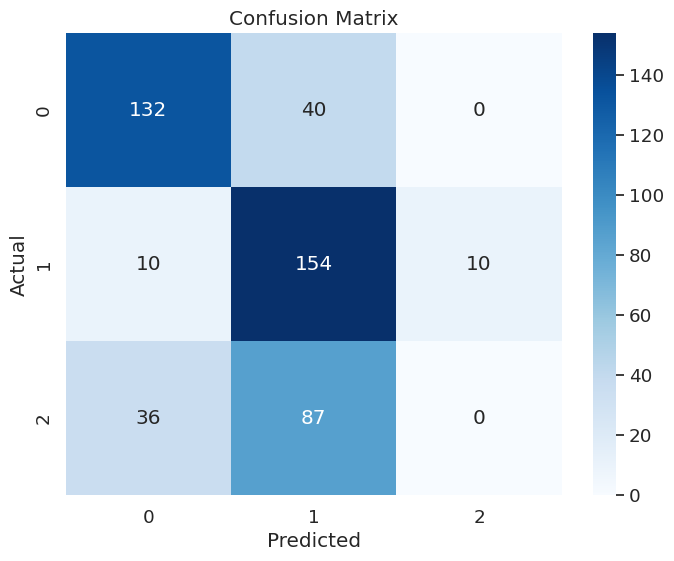

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming correct_predictions and predicted_labels are your data
correct_predictions = [0, 1, 2, 0, 1, 2, 0, 1, 2]
predicted_labels = [0, 1, 2, 1, 0, 1, 2, 0, 2]

# Get unique labels from the data
labels = [0,1,2]

# Create the confusion matrix
conf_matrix = confusion_matrix(original_labels_list, predicted_labels_list, labels=labels)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [86]:
from sklearn.metrics import classification_report

# Assuming original_labels_list and predicted_labels_list are your data


# Get unique labels from the data
labels = sorted(set(original_labels_list + predicted_labels_list))

# Compute the classification report
class_report = classification_report(original_labels_list, predicted_labels_list, labels=labels)

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       172
           1       0.55      0.89      0.68       174
           2       0.00      0.00      0.00       123

    accuracy                           0.61       469
   macro avg       0.43      0.55      0.48       469
weighted avg       0.48      0.61      0.53       469



In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming original_labels_list and predicted_labels_list are your data
# Assuming labels are [0, 1, 2] for the three classes

# Get unique labels from the data
labels = [0, 1, 2]

# Initialize dictionaries to store precision, recall, and F1 scores for each class
precision_per_class = {}
recall_per_class = {}
f1_per_class = {}

# Compute precision, recall, and F1 score for each class
for label in labels:
    precision_per_class[label] = precision_score(original_labels_list, predicted_labels_list, labels=[label], average='micro')
    recall_per_class[label] = recall_score(original_labels_list, predicted_labels_list, labels=[label], average='micro')
    f1_per_class[label] = f1_score(original_labels_list, predicted_labels_list, labels=[label], average='micro')

# Compute micro averages
micro_precision = precision_score(original_labels_list, predicted_labels_list, average='micro')
micro_recall = recall_score(original_labels_list, predicted_labels_list, average='micro')
micro_f1 = f1_score(original_labels_list, predicted_labels_list, average='micro')

# Compute macro averages
macro_precision = sum(precision_per_class.values()) / len(precision_per_class)
macro_recall = sum(recall_per_class.values()) / len(recall_per_class)
macro_f1 = sum(f1_per_class.values()) / len(f1_per_class)

# Print or use the results as needed
print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)
print("Micro F1 Score:", micro_f1)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

# Print precision, recall, and F1 scores for each class
for label in labels:
    print(f"Class {label} - Micro Precision: {precision_per_class[label]}, Micro Recall: {recall_per_class[label]}, Micro F1 Score: {f1_per_class[label]}")

    # Calculate macro F1 for each class
    precision_class = precision_score(original_labels_list, predicted_labels_list, labels=[label], average='macro')
    recall_class = recall_score(original_labels_list, predicted_labels_list, labels=[label], average='macro')
    f1_class = f1_score(original_labels_list, predicted_labels_list, labels=[label], average='macro')

    print(f"Class {label} - Macro Precision: {precision_class}, Macro Recall: {recall_class}, Macro F1 Score: {f1_class}")


Micro Precision: 0.6098081023454158
Micro Recall: 0.6098081023454158
Micro F1 Score: 0.6098081023454158
Macro Precision: 0.4298719127780666
Macro Recall: 0.5508331105764946
Macro F1 Score: 0.47706959706959706
Class 0 - Micro Precision: 0.7415730337078652, Micro Recall: 0.7674418604651163, Micro F1 Score: 0.7542857142857143
Class 0 - Macro Precision: 0.7415730337078652, Macro Recall: 0.7674418604651163, Macro F1 Score: 0.7542857142857143
Class 1 - Micro Precision: 0.5480427046263345, Micro Recall: 0.8850574712643678, Micro F1 Score: 0.6769230769230768
Class 1 - Macro Precision: 0.5480427046263345, Macro Recall: 0.8850574712643678, Macro F1 Score: 0.6769230769230768
Class 2 - Micro Precision: 0.0, Micro Recall: 0.0, Micro F1 Score: 0.0
Class 2 - Macro Precision: 0.0, Macro Recall: 0.0, Macro F1 Score: 0.0
